In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle
import os.path
import re
import nltk

from nltk.corpus import stopwords
from bs4 import BeautifulSoup

#nltk.download()

In [2]:
train = pd.read_csv("labeledTrainData.tsv", header=0, \
                    delimiter="\t", quoting=3)

print("Training column names: {}".format(train.columns.values))
print("First row of the data frame: \n{}".format(train.iloc[[0]]))

Training column names: ['id' 'sentiment' 'review']
First row of the data frame: 
         id  sentiment                                             review
0  "5814_8"          1  "With all this stuff going down at the moment ...


In [57]:
def review_to_words( raw_review ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review, "html.parser").get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))   

In [58]:
review_to_words(train["review"][0])

'stuff going moment mj started listening music watching odd documentary watched wiz watched moonwalker maybe want get certain insight guy thought really cool eighties maybe make mind whether guilty innocent moonwalker part biography part feature film remember going see cinema originally released subtle messages mj feeling towards press also obvious message drugs bad kay visually impressive course michael jackson unless remotely like mj anyway going hate find boring may call mj egotist consenting making movie mj fans would say made fans true really nice actual feature film bit finally starts minutes excluding smooth criminal sequence joe pesci convincing psychopathic powerful drug lord wants mj dead bad beyond mj overheard plans nah joe pesci character ranted wanted people know supplying drugs etc dunno maybe hates mj music lots cool things like mj turning car robot whole speed demon sequence also director must patience saint came filming kiddy bad sequence usually directors hate workin

In [69]:
clean_train_reviews_file = "clean_train_reviews.pickle"
clean_train_reviews = []

if os.path.isfile(clean_train_reviews_file):
    with open(clean_train_reviews_file, 'rb') as f:
        clean_train_reviews = pickle.load(f)

In [70]:
if not clean_train_reviews:
    
    # Get the number of reviews based on the dataframe column size
    num_reviews = train["review"].size

    print("Cleaning and parsing the training set movie reviews...\n")

    for i in range(num_reviews):
        # If the index is evenly divisible by 1000, print a message
        if ((i+1)%5000 == 0):
            print("Review %d of %d" % (i+1, num_reviews))
        clean_train_reviews.append(review_to_words(train["review"][i]))
    
    with open(clean_train_reviews_file, 'wb') as f:
        pickle.dump(clean_train_reviews, f, pickle.HIGHEST_PROTOCOL)

Cleaning and parsing the training set movie reviews...

Review 5000 of 25000
Review 10000 of 25000
Review 15000 of 25000
Review 20000 of 25000
Review 25000 of 25000


In [91]:
print("Creating the bag of words...\n")
from sklearn.feature_extraction.text import CountVectorizer

vocabulary_size = 5000

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = vocabulary_size) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
train_data_features = vectorizer.fit_transform(clean_train_reviews)

# Numpy arrays are easy to work with, so convert the result to an 
# array
train_data_features = train_data_features.toarray()

Creating the bag of words...



In [81]:
num_nonzero = np.count_nonzero(train_data_features)
print("Train data: {}".format(train_data_features.shape))
print("Total elements: {}".format(train_data_features.size))
print("Nonzero elements: {}".format(num_nonzero))

print("Nonzero fraction: {}".format(num_nonzero/train_data_features.size))

Train data: (25000, 5000)
Total elements: 125000000
Nonzero elements: 1975048
Nonzero fraction: 0.015800384


In [86]:
# Take a look at the words in the vocabulary
vocab = vectorizer.get_feature_names()
print(vocab[:10])

['abandoned', 'abc', 'abilities', 'ability', 'able', 'abraham', 'absence', 'absent', 'absolute', 'absolutely']


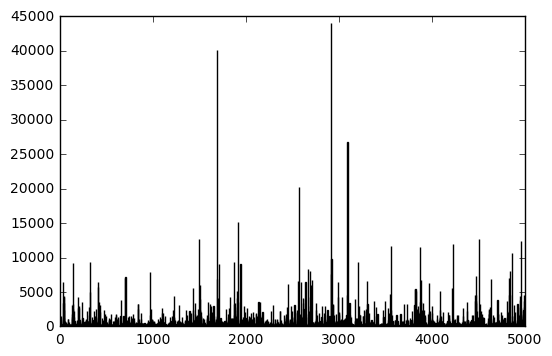

In [93]:
# Sum up the counts of each vocabulary word
dist = np.sum(train_data_features, axis=0)

plt.bar(range(vocabulary_size), dist)
plt.show()

In [120]:
ind_sort = np.argsort(dist)[::-1]

print("Count word")
print("----------")
for i in ind_sort[:10]:
    print(dist[i], vocab[i])

Count word
----------
44031 movie
40147 film
26788 one
20274 like
15140 good
12724 time
12646 even
12436 would
11983 story
11736 really


In [124]:
random_forest_file = "random_forest.pickle"
forest = None

if os.path.isfile(random_forest_file):
    with open(random_forest_file, 'rb') as f:
        forest = pickle.load(f)

In [125]:
if not forest:
    print("Training the random forest...")
    from sklearn.ensemble import RandomForestClassifier

    # Initialize a Random Forest classifier with 100 trees
    forest = RandomForestClassifier(n_estimators = 100) 

    # Fit the forest to the training set, using the bag of words as 
    # features and the sentiment labels as the response variable
    forest = forest.fit( train_data_features, train["sentiment"] )
    
    with open(random_forest_file, 'wb') as f:
        pickle.dump(forest, f, pickle.HIGHEST_PROTOCOL)

In [129]:
# Read the test data
test = pd.read_csv("testData.tsv", header=0, delimiter="\t", \
                   quoting=3 )

# Verify that there are 25,000 rows and 2 columns
print(test.shape)

# Create an empty list and append the clean reviews one by one
num_reviews = len(test["review"])
clean_test_reviews = [] 

print("Cleaning and parsing the test set movie reviews...\n")
for i in range(num_reviews):
    if ((i+1) % 5000 == 0):
        print("Review %d of %d" % (i+1, num_reviews))
    clean_review = review_to_words(test["review"][i])
    clean_test_reviews.append(clean_review)

# Get a bag of words for the test set, and convert to a numpy array
test_data_features = vectorizer.transform(clean_test_reviews)
test_data_features = test_data_features.toarray()

# Use the random forest to make sentiment label predictions
result = forest.predict(test_data_features)

# Copy the results to a pandas dataframe with an "id" column and
# a "sentiment" column
output = pd.DataFrame( data={"id":test["id"], "sentiment":result} )

# Use pandas to write the comma-separated output file
output.to_csv("Bag_of_Words_model.csv", index=False, quoting=3)

(25000, 2)
Cleaning and parsing the test set movie reviews...

Review 5000 of 25000
Review 10000 of 25000
Review 15000 of 25000
Review 20000 of 25000
Review 25000 of 25000
